1. Import and Install Dependencies

1.1 Install Dependencies

In [1]:
!pip install tensorflow matplotlib tensorflow-io

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import librosa
from sklearn import preprocessing
import random as rn
from keras.layers import Dense
from keras import Input
from tensorflow.keras.models import Model
from keras.utils import to_categorical
from keras.layers import Dense, TimeDistributed, Dropout, Bidirectional, GRU, BatchNormalization, Activation, LeakyReLU, LSTM, Flatten, RepeatVector, Permute, Multiply, Conv2D, MaxPooling2D
import tensorflow as tf
import random

2023-10-24 13:24:45.201707: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-24 13:24:46.173108: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2. Data Loading

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2023-10-24 13:24:47.328131: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-24 13:24:47.399428: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-24 13:24:47.399508: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=3072)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

2023-10-24 13:24:47.419488: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


1 Physical GPUs, 1 Logical GPUs


2023-10-24 13:24:47.419693: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-24 13:24:47.419737: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-24 13:24:48.513622: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-24 13:24:48.513648: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1726] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2023-10-24 13:24:48.513712: I tensorflow/compiler/xla/stream_executor/cuda/cu

In [5]:
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
DATA_DIR = os.path.join('data', 'train/')

In [7]:
wav, sr = librosa.load(DATA_DIR + 'Q-01.wav', sr=16000)
print('sr:', sr)
print('wav shape:', wav.shape)
print('length:', wav.shape[0]/float(sr), 'secs')

sr: 16000
wav shape: (7040,)
length: 0.44 secs


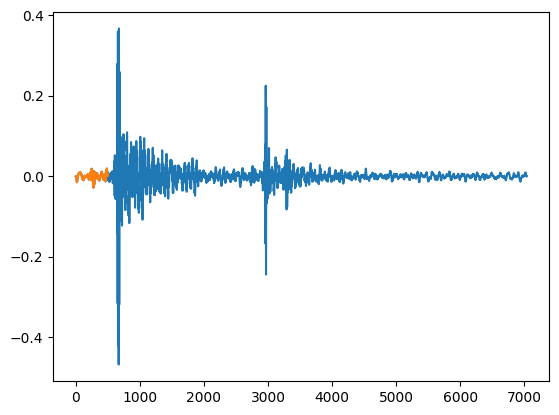

In [8]:
# raw wave
print(plt.plot(wav))
print(plt.plot(wav[0:500]))

In [9]:
train_X = []
train_spectrograms = []
train_mel_spectrograms = []
train_mfccs = []
train_y = []

test_X = []
test_spectrograms = []
test_mel_spectrograms = []
test_mfccs = []
test_y = []

# 모든 음성파일의 길이가 같도록 후위에 padding 처리
pad1d = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i-a.shape[0])))
pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))

frame_length = 0.025
frame_stride = 0.0010

In [10]:
from sklearn.model_selection import train_test_split

def get_labels(filename):
  if filename[0] == 'Q':
    return 0
  elif filename[0] == 'W':
    return 1
  elif filename[0] == 'E':
    return 2
  elif filename[0] == 'R':
    return 3


simple MLP with raw waves

In [11]:
X = []
y = []

for filename in os.listdir(DATA_DIR):
    if '.wav' not in filename:
        continue
    
    wav, sr = librosa.load(DATA_DIR + filename)
    padded_x = pad1d(wav, 30000)
    label = get_labels(filename)

    X.append(padded_x)
    y.append(label)
        
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
train_X = np.vstack(train_X)
train_y = to_categorical(np.array(train_y))

test_X = np.vstack(test_X)
test_y = to_categorical(np.array(test_y))


print('train_X:', train_X.shape)
print('train_y:', train_y.shape)

print('test_X:', test_X.shape)
print('test_y:', test_y.shape) 

train_X: (104, 30000)
train_y: (104, 4)
test_X: (27, 30000)
test_y: (27, 4)


In [13]:
from keras.models import Sequential
from keras.layers import Dense, Flatten

model = Sequential()
model.add(Flatten(input_shape=train_X.shape[1:]))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(train_y.shape[1], activation='softmax'))

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_X,
                    train_y,
                    epochs=50,
                    batch_size=32,
                    validation_data=(test_X, test_y))

Epoch 1/50


2023-10-24 13:24:51.916600: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc49c0f65b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-24 13:24:51.916642: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2023-10-24 13:24:51.921737: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-24 13:24:52.058546: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-24 13:24:52.233545: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/4 [==============================] - 2s 64ms/step - loss: 1.3783 - accuracy: 0.2788 - val_loss: 1.3676 - val_accuracy: 0.3333
Epoch 2/50
4/4 [==============================] - 0s 18ms/step - loss: 1.2224 - accuracy: 0.6731 - val_loss: 1.3470 - val_accuracy: 0.2963
Epoch 3/50
4/4 [==============================] - 0s 17ms/step - loss: 1.0726 - accuracy: 0.8077 - val_loss: 1.3217 - val_accuracy: 0.3333
Epoch 4/50
4/4 [==============================] - 0s 17ms/step - loss: 0.9243 - accuracy: 0.8654 - val_loss: 1.3019 - val_accuracy: 0.3704
Epoch 5/50
4/4 [==============================] - 0s 17ms/step - loss: 0.7822 - accuracy: 0.8846 - val_loss: 1.2969 - val_accuracy: 0.3333
Epoch 6/50
4/4 [==============================] - 0s 16ms/step - loss: 0.6431 - accuracy: 0.9327 - val_loss: 1.3011 - val_accuracy: 0.3333
Epoch 7/50
4/4 [==============================] - 0s 17ms/step - loss: 0.5146 - accuracy: 0.9904 - val_loss: 1.3065 - val_accuracy: 0.3704
Epoch 8/50
4/4 [======================

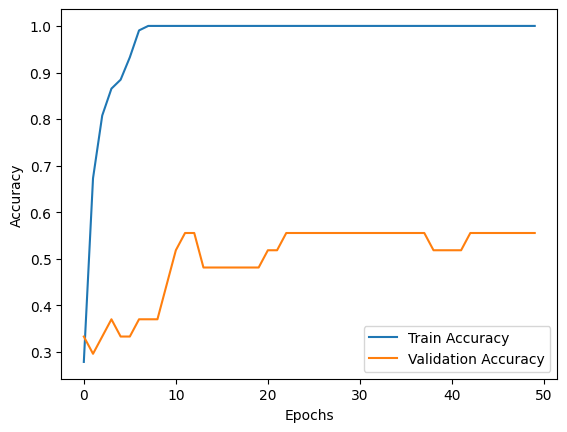

In [15]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


Train accuracy okay, test accuracy very low. 

MFCC feature로 학습

In [16]:
def get_mfcc(filename):
  wav, sr = librosa.load(filename, sr=16000)
  mfcc = librosa.feature.mfcc(y=wav, sr=16000, n_mfcc=100, n_fft=400, hop_length=160)
  mfcc = mfcc/ 1000000
  mfcc = preprocessing.scale(mfcc, axis=1)
  padded_mfcc = pad2d(mfcc, 40)
  return padded_mfcc

X = []
y = []
for filename in os.listdir(DATA_DIR):
    if '.wav' not in filename:
        continue
    mfcc = get_mfcc(DATA_DIR + filename)
    label = get_labels(filename)

    X.append(mfcc)
    y.append(label)

train_mfccs, test_mfccs, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
train_mfccs = np.array(train_mfccs)
train_y = to_categorical(np.array(train_y))

test_mfccs = np.array(test_mfccs)
test_y = to_categorical(np.array(test_y))

print('train_mfccs:', train_mfccs.shape)
print('train_y:', train_y.shape)

print('test_mfccs:', test_mfccs.shape)
print('test_y:', test_y.shape)

train_mfccs: (104, 100, 40)
train_y: (104, 4)
test_mfccs: (27, 100, 40)
test_y: (27, 4)


In [18]:
train_mfccs = np.expand_dims(train_mfccs, -1)
test_mfccs = np.expand_dims(test_mfccs, -1)
print('train X shape:', train_mfccs.shape)
print('test X shape:', test_mfccs.shape)

train X shape: (104, 100, 40, 1)
test X shape: (27, 100, 40, 1)


In [19]:
ip = Input(shape=train_mfccs[0].shape)

m = Conv2D(32, kernel_size=(4,4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4,4))(m)

m = Conv2D(32*2, kernel_size=(4,4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4,4))(m)

m = Conv2D(32 * 3, kernel_size=(4, 4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4,4))(m)

m = Flatten()(m)

m = Dense(64, activation='relu')(m)

m = Dense(32, activation='relu')(m)

op = Dense(4, activation='softmax')(m)

model = Model(ip, op)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 40, 1)]      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 97, 37, 96)        1632      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 24, 9, 96)         0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 20736)             0         
                                                                 
 dense_3 (Dense)             (None, 64)                1327168   
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                             

In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_mfccs,
                    train_y,
                    epochs=100,
                    batch_size=32,
                    verbose=1,
                    validation_data=(test_mfccs, test_y))


Epoch 1/100
4/4 [==============================] - 3s 82ms/step - loss: 2.1194 - accuracy: 0.3365 - val_loss: 1.9230 - val_accuracy: 0.2963
Epoch 2/100
4/4 [==============================] - 0s 17ms/step - loss: 1.6035 - accuracy: 0.2692 - val_loss: 1.5197 - val_accuracy: 0.2593
Epoch 3/100
4/4 [==============================] - 0s 17ms/step - loss: 1.4449 - accuracy: 0.3173 - val_loss: 1.3632 - val_accuracy: 0.4444
Epoch 4/100
4/4 [==============================] - 0s 17ms/step - loss: 1.3418 - accuracy: 0.4231 - val_loss: 1.2563 - val_accuracy: 0.2593
Epoch 5/100
4/4 [==============================] - 0s 18ms/step - loss: 1.1417 - accuracy: 0.4423 - val_loss: 1.2281 - val_accuracy: 0.2593
Epoch 6/100
4/4 [==============================] - 0s 17ms/step - loss: 1.0390 - accuracy: 0.7404 - val_loss: 1.1573 - val_accuracy: 0.2963
Epoch 7/100
4/4 [==============================] - 0s 17ms/step - loss: 1.0239 - accuracy: 0.5000 - val_loss: 1.0031 - val_accuracy: 0.7407
Epoch 8/100
4/4 [===

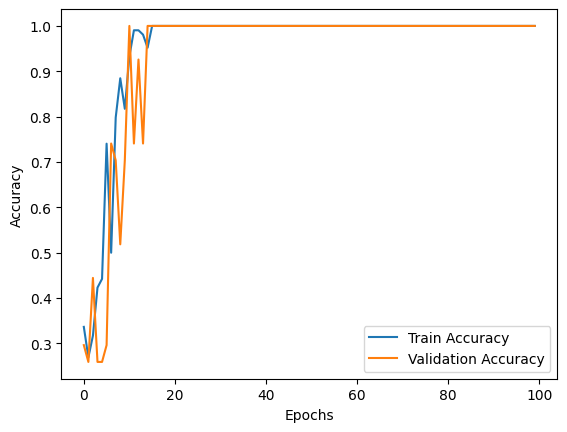

In [21]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Text(0, 0.5, 'Accuracy [%]')

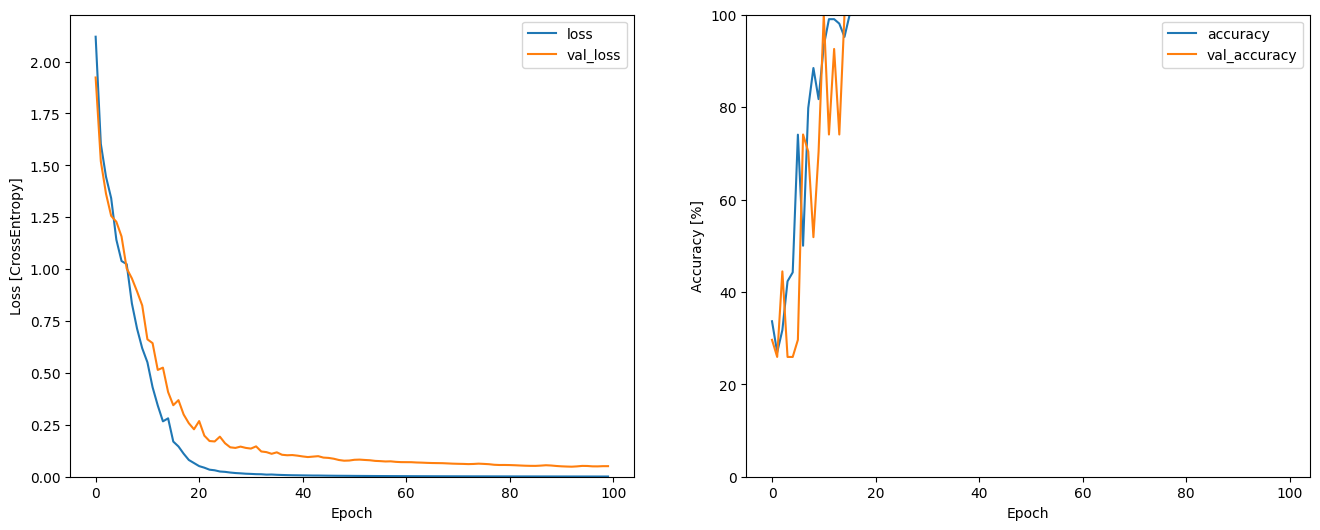

In [22]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

Model Test

In [23]:
filename = (DATA_DIR + 'Q-08.wav')
mfcc = get_mfcc(filename)
prediction = model.predict(mfcc)
plt.bar(["Q", "W", "E", "R"], tf.nn.softmax(prediction[0]))
plt.title('Q')
plt.show()
prediction

ValueError: in user code:

    File "/home/hyochung/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "/home/hyochung/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/hyochung/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "/home/hyochung/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 2283, in predict_step
        return self(x, training=False)
    File "/home/hyochung/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/hyochung/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 100, 40, 1), found shape=(None, 40)


In [ ]:
filename = (DATA_DIR + 'W-08.wav')
mfcc = get_mfcc(filename)
prediction = model.predict(mfcc)
plt.bar(["Q", "W", "E", "R"], tf.nn.softmax(prediction[0]))
plt.title('W')
plt.show()
prediction

In [ ]:
filename = (DATA_DIR + 'E-08.wav')
mfcc = get_mfcc(filename)
prediction = model.predict(mfcc)
plt.bar(["Q", "W", "E", "R"], tf.nn.softmax(prediction[0]))
plt.title('E')
plt.show()
prediction

In [ ]:
filename = (DATA_DIR + 'R-08.wav')
mfcc = get_mfcc(filename)
prediction = model.predict(mfcc)
plt.bar(["Q", "W", "E", "R"], tf.nn.softmax(prediction[0]))
plt.title('R')
plt.show()
prediction

In [ ]:
model.save('/home/hyochung/Keyboard_DL')

INFO:tensorflow:Assets written to: /home/hyochung/Keyboard_DL/assets


INFO:tensorflow:Assets written to: /home/hyochung/Keyboard_DL/assets


Long Audio testing

In [ ]:
#긴 오디오
wav, sr = librosa.load(DATA_DIR + 'E-17.wav', sr=None)
print('sr:', sr)
print('wav shape:', wav.shape)
print('length:', wav.shape[0]/float(sr), 'secs')

sr: 44100
wav shape: (21609,)
length: 0.49 secs


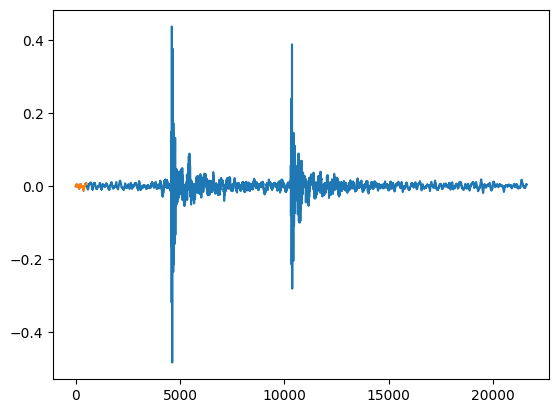

In [ ]:
# raw wave
print(plt.plot(wav))
print(plt.plot(wav[0:500]))

In [ ]:
audio, sr = librosa.load(DATA_DIR + 'R-23.wav')
mfcc = librosa.feature.mfcc(y=wav, sr=16000, n_mfcc=100, n_fft=400, hop_length=160)
mfcc = preprocessing.scale(mfcc, axis=1)
padded_mfcc = pad2d(mfcc, 40)
padded_mfcc= np.expand_dims(padded_mfcc, 0)
     

/home/hyochung/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:246: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/hyochung/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:265: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


In [ ]:
def get_prediction(prediction_value):
  if prediction_value == 0:
    return 'Q'
  elif prediction_value == 1:
    return 'W'
  elif prediction_value == 2:
    return 'E'
  elif prediction_value == 3:
    return 'R'

prediction = model.predict(padded_mfcc)
print(prediction)
prediction_value = np.argmax(prediction)

print(f"The model predicts the label: {get_prediction(prediction_value)}")

1/1 [==============================] - 0s 24ms/step
[[0.6466424  0.32648277 0.01645159 0.01042324]]
The model predicts the label: Q


Spectogram

In [ ]:
def get_spectrogram(filename):
    wav, sr = librosa.load(filename, sr=16000)
    spectrogram = np.abs(librosa.stft(wav))
    padded_spectrogram = pad2d(spectrogram, 40)
    return padded_spectrogram

X = []
y = []
for filename in os.listdir(DATA_DIR):
    if '.wav' not in filename:
        continue

    spectrogram = get_spectrogram(DATA_DIR + filename)
    label = get_labels(filename)

    X.append(spectrogram)
    y.append(label)


train_spectrograms, test_spectrograms, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
train_spectrograms = np.array(train_spectrograms)
train_y = to_categorical(np.array(train_y))

test_spectrograms = np.array(test_spectrograms)
test_y = to_categorical(np.array(test_y))

print('train_mfccs:', train_spectrograms.shape)
print('train_y:', train_y.shape)

print('test_mfccs:', test_spectrograms.shape)
print('test_y:', test_y.shape)

train_mfccs: (104, 1025, 40)
train_y: (104, 4)
test_mfccs: (27, 1025, 40)
test_y: (27, 4)


Spectogram feature training

In [ ]:
train_spectrograms = np.expand_dims(train_spectrograms, -1)
test_spectrograms = np.expand_dims(test_spectrograms, -1)
print('train_spectograms shape:', train_spectrograms.shape)
print('test_spectograms shape:', test_spectrograms.shape)

train_spectograms shape: (104, 1025, 40, 1)
test_spectograms shape: (27, 1025, 40, 1)


In [ ]:
ip = Input(shape=train_spectrograms[0].shape)

m = Conv2D(32, kernel_size=(4,4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4,4))(m)

m = Conv2D(32*2, kernel_size=(4,4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4,4))(m)

m = Conv2D(32 * 3, kernel_size=(4, 4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4,4))(m)

m = Flatten()(m)

m = Dense(64, activation='relu')(m)

m = Dense(32, activation='relu')(m)

op = Dense(4, activation='softmax')(m)

model = Model(ip, op)

model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1025, 40, 1)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 1022, 37, 96)      1632      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 255, 9, 96)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 220320)            0         
                                                                 
 dense_6 (Dense)             (None, 64)                14100544  
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                           

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_spectrograms,
                    train_y,
                    epochs=100,
                    batch_size=32,
                    verbose=1,
                    validation_data=(test_spectrograms, test_y))

Epoch 1/100
4/4 [==============================] - 2s 220ms/step - loss: 2.2665 - accuracy: 0.2788 - val_loss: 0.6311 - val_accuracy: 0.8519
Epoch 2/100
4/4 [==============================] - 0s 108ms/step - loss: 0.7461 - accuracy: 0.6154 - val_loss: 0.5334 - val_accuracy: 0.7407
Epoch 3/100
4/4 [==============================] - 0s 108ms/step - loss: 0.4147 - accuracy: 0.7981 - val_loss: 0.2351 - val_accuracy: 0.9630
Epoch 4/100
4/4 [==============================] - 0s 112ms/step - loss: 0.2094 - accuracy: 0.9519 - val_loss: 0.1590 - val_accuracy: 1.0000
Epoch 5/100
4/4 [==============================] - 0s 112ms/step - loss: 0.1341 - accuracy: 0.9904 - val_loss: 0.0863 - val_accuracy: 1.0000
Epoch 6/100
4/4 [==============================] - 0s 116ms/step - loss: 0.0646 - accuracy: 0.9808 - val_loss: 0.0634 - val_accuracy: 1.0000
Epoch 7/100
4/4 [==============================] - 0s 114ms/step - loss: 0.0513 - accuracy: 0.9808 - val_loss: 0.0372 - val_accuracy: 1.0000
Epoch 8/100
4

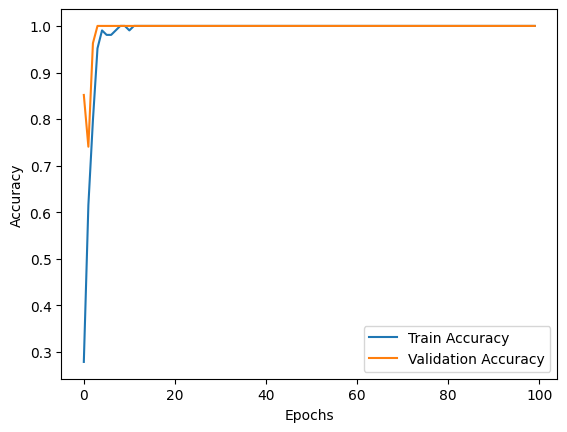

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Text(0, 0.5, 'Accuracy [%]')

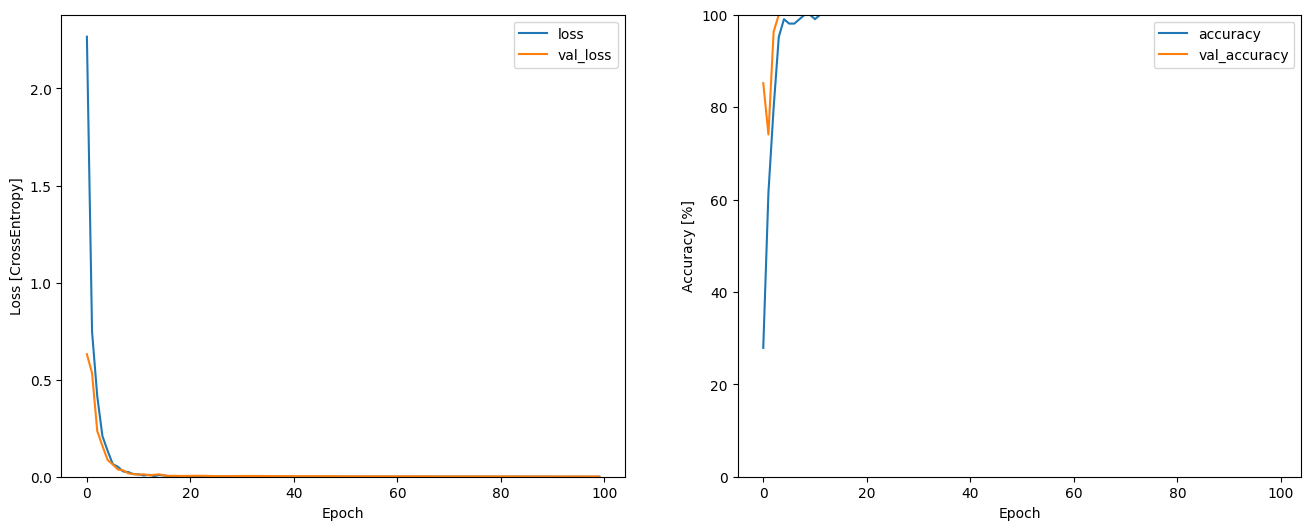

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [ ]:
model.evaluate(test_spectrograms, return_dict=True)

1/1 [==============================] - 0s 62ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


{'loss': 0.0, 'accuracy': 0.0}

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


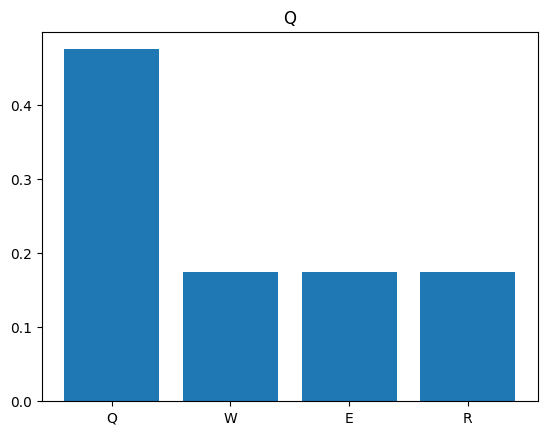

array([[9.9999988e-01, 1.1705299e-09, 1.2701656e-07, 3.5494166e-10]],
      dtype=float32)

In [ ]:
filename = (DATA_DIR + 'Q-08.wav')
spectrogram = get_spectrogram(filename)
spectrogram = np.expand_dims(spectrogram, 0)
prediction = model.predict(spectrogram)
plt.bar(["Q", "W", "E", "R"], tf.nn.softmax(prediction[0]))
plt.title('Q')
plt.show()
prediction

1/1 [==============================] - 0s 18ms/step


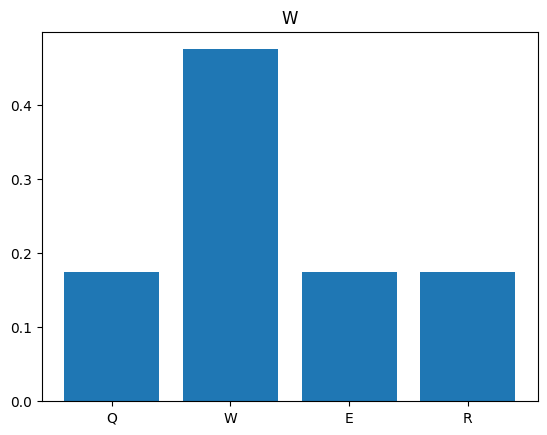

array([[9.253023e-07, 9.999783e-01, 2.068375e-05, 9.596699e-10]],
      dtype=float32)

In [ ]:
filename = (DATA_DIR + 'W-13.wav')
spectrogram = get_spectrogram(filename)
spectrogram = np.expand_dims(spectrogram, 0)
prediction = model.predict(spectrogram)
plt.bar(["Q", "W", "E", "R"], tf.nn.softmax(prediction[0]))
plt.title('W')
plt.show()
prediction

1/1 [==============================] - 0s 20ms/step


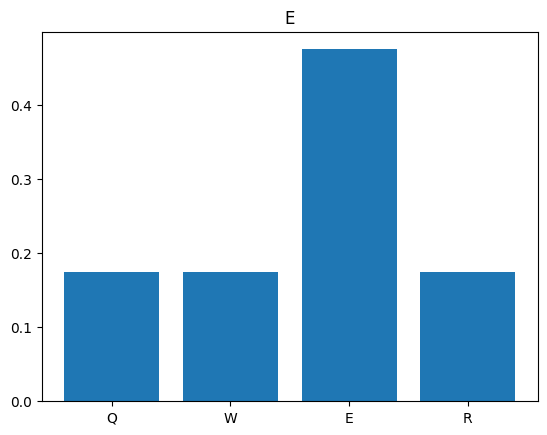

In [ ]:
filename = (DATA_DIR + 'E-13.wav')
spectrogram = get_spectrogram(filename)
spectrogram = np.expand_dims(spectrogram, 0)
prediction = model.predict(spectrogram)
plt.bar(["Q", "W", "E", "R"], tf.nn.softmax(prediction[0]))
plt.title('E')
plt.show()

1/1 [==============================] - 0s 17ms/step


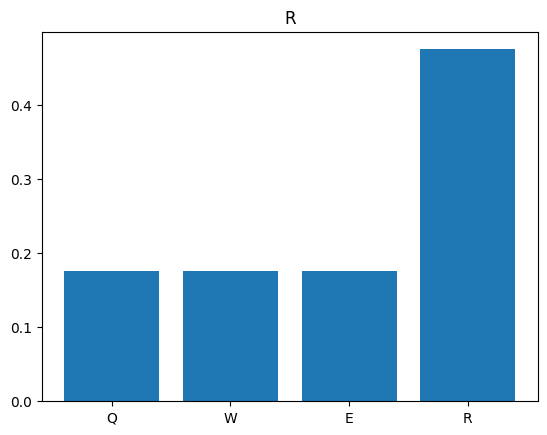

In [ ]:
filename = (DATA_DIR + 'R-30.wav')
spectrogram = get_spectrogram(filename)
spectrogram = np.expand_dims(spectrogram, 0)
prediction = model.predict(spectrogram)
plt.bar(["Q", "W", "E", "R"], tf.nn.softmax(prediction[0]))
plt.title('R')
plt.show()